In [ ]:
# This is my attempt at writing a basic CNN to classify the following data set.
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# This contains roughly 6000 chest x-rays of children <5 years old who test either positively or negatively for 
# pneumonia. I use a basic 3 layer CNN with one fully connected layer to classify these images. 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
from keras.metrics import AUC
%matplotlib inline
#Import the basic toolkits we will be using 

In [2]:
project_path = "/Users/sean/desktop/ML_Projects/Pneumonia_China_Under_5"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"
os.environ['KMP_DUPLICATE_LIB_OK']='True'#need this otherwise Keras won't run properly due to issue with TF installation.


In [3]:
len_train_set = len(os.listdir(train_path+"NORMAL"))+len(os.listdir(train_path+"PNEUMONIA"))
len_train_set_NORMAL = len(os.listdir(train_path+"NORMAL"))
len_train_set_PNEUMONIA = len(os.listdir(train_path+"PNEUMONIA"))
len_test_set = len(os.listdir(test_path+"NORMAL"))+len(os.listdir(test_path+"PNEUMONIA"))
len_test_set_NORMAL = len(os.listdir(test_path+"NORMAL"))
len_test_set_PNEUMONIA = len(os.listdir(test_path+"PNEUMONIA"))
len_val_set = len(os.listdir(val_path+"NORMAL"))+len(os.listdir(val_path+"PNEUMONIA"))
len_val_set_NORMAL = len(os.listdir(val_path+"NORMAL"))
len_val_set_PNEUMONIA = len(os.listdir(val_path+"PNEUMONIA"))
print("The train set has length {}.\nThere are {} NORMAL and {} PNEUMONIA cases".format(len_train_set,len_train_set_NORMAL,len_train_set_PNEUMONIA))
print("\n")
print("The test set has length {}.\nThere are {} NORMAL and {} PNEUMONIA cases".format(len_test_set,len_test_set_NORMAL,len_test_set_PNEUMONIA))
print("\n")
print("The validation set has length {}.\nThere are {} NORMAL and {} PNEUMONIA cases".format(len_val_set,len_val_set_NORMAL,len_val_set_PNEUMONIA))

The train set has length 5158.
There are 1312 NORMAL and 3846 PNEUMONIA cases


The test set has length 624.
There are 234 NORMAL and 390 PNEUMONIA cases


The validation set has length 77.
There are 38 NORMAL and 39 PNEUMONIA cases


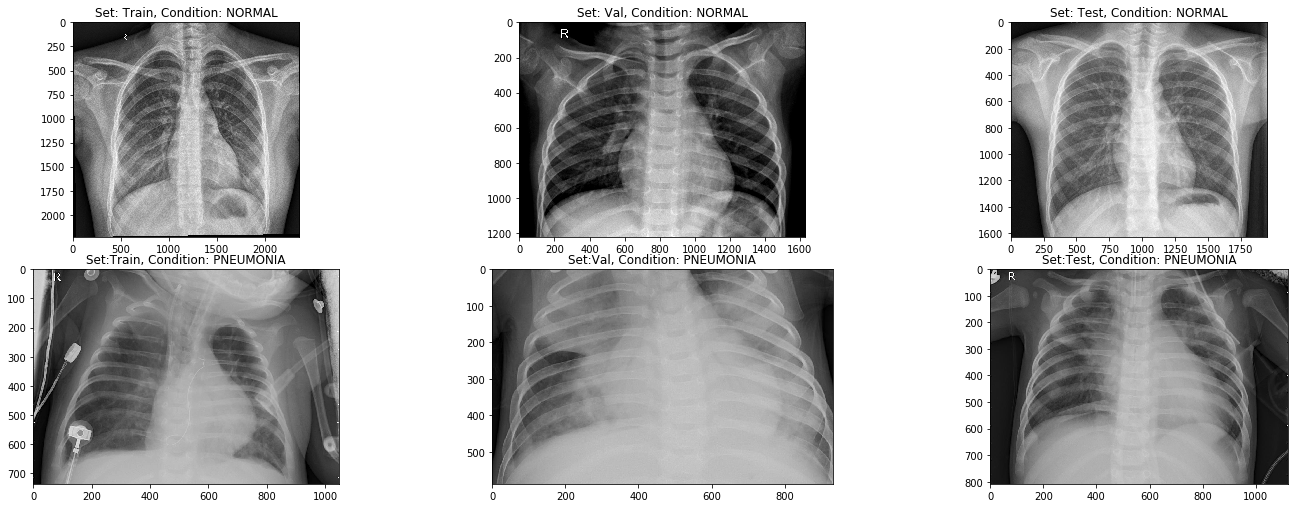

In [4]:
#Examples from each dataset for each classification. 
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,7))
axes=axes.ravel()
plt.tight_layout()
pic_labels = ['Train','Val',"Test"]
for i,_folder in enumerate([train_path,val_path,test_path]):
    axes[i].imshow(plt.imread(_folder+"/NORMAL/"+os.listdir(_folder+'/NORMAL')[0]),cmap='gray')
    axes[i].set_title('Set: {}, Condition: NORMAL'.format(pic_labels[i]))
    axes[i+3].imshow(plt.imread(_folder+"/PNEUMONIA/"+os.listdir(_folder+'/PNEUMONIA')[0]),cmap='gray')
    axes[i+3].set_title('Set:{}, Condition: PNEUMONIA'.format(pic_labels[i]))

In [5]:
train_datagen = ImageDataGenerator(
        rescale = 1.0/255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

#Rescale the data so that pixel values are in range [0,1]

In [93]:
print(plt.imread(_folder+"/NORMAL/"+os.listdir(_folder+'/NORMAL')[12]).shape)
print(plt.imread(_folder+"/NORMAL/"+os.listdir(_folder+'/NORMAL')[3]).shape)
# Observe that the images in the data set have different sizes. To account for this when we construct 
# the train/val/test generators we will rescale all images to a certain size (64x64)

(1418, 1856)
(2152, 2366)


In [6]:
target_dimension = 64
batch = 128
colour = 'grayscale'
# We have images in 3 directories (train/val/test). We now want to turn these images into data that we can feed into
# the network. We do this using train_datagen.flow._from_directory (resp val/test). This takes in our directory 
# (train_path) and converts the images into a form that we can input into the model (i.e. gives the images in the 
# directory a label (PNEUMONIA or NORMAL).
# We pick a batchsize and specify a class mode (binary, since there are only 2 possibilities)


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (target_dimension, target_dimension),
                                                    batch_size = batch, 
                                                    color_mode = colour,
                                                    class_mode = 'binary', 
                                                    seed = 42)

val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                    target_size = (target_dimension, target_dimension),
                                                    batch_size = batch, 
                                                    color_mode = colour,
                                                    class_mode = 'binary', 
                                                    shuffle = False,
                                                    seed = 42)

test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                    target_size = (target_dimension, target_dimension),
                                                    batch_size = batch, 
                                                    color_mode = colour,
                                                    class_mode = 'binary', 
                                                    shuffle = False,
                                                    seed = 42)
test_generator.reset()#need to reset test generator or else the predictions will be in a weird order

Found 5156 images belonging to 2 classes.
Found 76 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(target_dimension, target_dimension, 1)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

# Basic CNN set up. Set up a Sequential instance and add some convolutional layers with max pooling. Final layer
# is a fully connected layer. 

In [8]:
cnn.summary()
#basic details of the model including # of parameters.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [9]:
cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
# compile the model using the adam optimiser. We use binary_cross entropy as the loss function (since we are 
# classifying two objects). We use AUC as the metric (obviously can use accuracy.)
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 30, 
                              validation_data = test_generator,
                              validation_steps = len(test_generator), 
                              verbose=1)
#Validation data only came with ~70 images. This gives pretty poor results so I used the test data (~600 images)
# instead. 

Epoch 1/30
41/41 [==============================] - 38s 935ms/step - loss: 0.5765 - auc_1: 0.5345 - val_loss: 0.3154 - val_auc_1: 0.7622
Epoch 2/30
41/41 [==============================] - 37s 909ms/step - loss: 0.3892 - auc_1: 0.8756 - val_loss: 0.3537 - val_auc_1: 0.9266
Epoch 3/30
41/41 [==============================] - 38s 916ms/step - loss: 0.2793 - auc_1: 0.9346 - val_loss: 0.4120 - val_auc_1: 0.9346
Epoch 4/30
41/41 [==============================] - 38s 916ms/step - loss: 0.2334 - auc_1: 0.9550 - val_loss: 0.2277 - val_auc_1: 0.9402
Epoch 5/30
41/41 [==============================] - 37s 914ms/step - loss: 0.2100 - auc_1: 0.9635 - val_loss: 0.1330 - val_auc_1: 0.9499
Epoch 6/30
41/41 [==============================] - 38s 921ms/step - loss: 0.2059 - auc_1: 0.9641 - val_loss: 0.0636 - val_auc_1: 0.9537
Epoch 7/30
41/41 [==============================] - 38s 920ms/step - loss: 0.2000 - auc_1: 0.9674 - val_loss: 0.2229 - val_auc_1: 0.9534
Epoch 8/30
41/41 [=======================

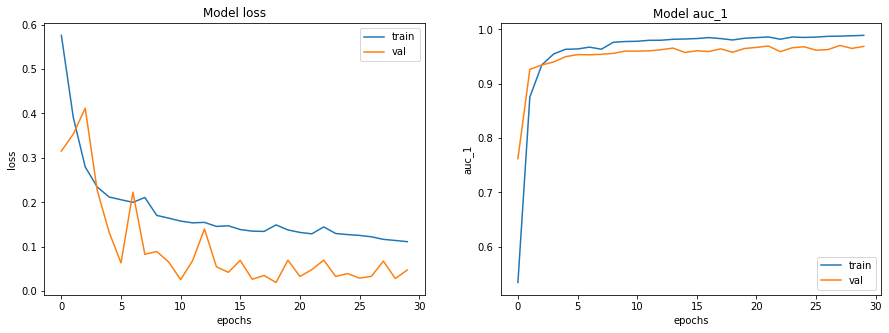

In [10]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
axes=axes.ravel()
for i,TYPE in enumerate(['loss','auc_1']):
    axes[i].plot(cnn.history.history[TYPE])
    axes[i].plot(cnn.history.history['val_'+TYPE])
    axes[i].set_title('Model {}'.format(TYPE))
    axes[i].set_xlabel('epochs')
    axes[i].set_ylabel(TYPE)
    axes[i].legend(['train', 'val'])
    fig

In [17]:
cnn.save("cnn.h5")
#save the model